# Домашнее задание 3. Буряк Константин, группа 2.


In [812]:
import numpy as np
import pandas as pd
import random

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, fbeta_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, MinMaxScaler, minmax_scale, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score 

from sklearn.feature_selection import f_regression, SelectKBest, f_classif, chi2, mutual_info_regression, SequentialFeatureSelector
from mlxtend.feature_selection import ExhaustiveFeatureSelector

import warnings
warnings.filterwarnings("ignore")

# Часть 1: минималочка [макс 20 баллов]

В этой части мы с вами попробуем построить самую простую модель для предсказания.

Как мы с вами увидим: главная сложность - правильная подготовка данных. В таких задачах то, как именно вы преобразуете данные для обучения модели и будет во много определять её качество.

В этой части мы сделаем простое преобразование данных путём простой агрегации данных о величине транзакций. 

## Загрузка данных [5 баллов] 

Скачайте данные для задачи с Яндекс.Диска:
https://disk.yandex.ru/d/DGy6bbLaMZmrQg.

Загрузите файлы с транзакциями и целевой меткой в pd.DataFrame.

__Внимание__: у файла transactions.csv колоночный разделитель - точка с запятой ";"

In [813]:
df_transactions = pd.read_csv('transactions.csv', sep=';') #Я добавляю загруженные с яндекса данные уже с моего компа, поэтому
print(df_transactions.shape)                     #для запуска необходимо добавить соответствующие таблички в файловую систему jupyter-а
df_transactions.head()

(2282467, 4)


,user_id,dt,type,value
0,39026145,0 10:23:26,"Звонки с использованием телефонов, считывающих...",2695.099
1,39026145,6 07:08:31,"Звонки с использованием телефонов, считывающих...",2358.212
2,39026145,8 07:06:10,"Звонки с использованием телефонов, считывающих...",2807.395
3,39026145,11 08:49:03,"Звонки с использованием телефонов, считывающих...",2695.099
4,39026145,11 14:12:08,"Звонки с использованием телефонов, считывающих...",2695.099


In [814]:
df_gender = pd.read_csv('gender.csv', sep=',')
print(df_gender.shape) 
df_gender.head() #всего 2 гендера?! 

(8400, 2)


,user_id,gender
0,6740969,1.0
1,36599781,0.0
2,91453656,1.0
3,17431962,1.0
4,72568668,1.0


## Подготовка данных [10 баллов] 

Для данной задачи необходимо как-то собрать данные для каждого пользователя в один вектор (строку таблицы). Сейчас, как вы можете увидеть, в таблице с данными одному пользователю может соответствовать много строк (каждая операция - отдельная строка).

Таким образом, необходима агрегация данных - это можно сделать множеством разных способов.

### Агрегация 

Произведите простую агрегацию данных и для каждого пользователя в качестве признаков получите сумму, среднее и стандартное отклонение величины его транзакций. 

Так же добавите для каждого пользователя колонку с таргетом.

По итогу вы должны получить таблицу с колонками:
* user_id
* value_sum
* value_mean
* value_std
* gender

In [815]:
len(df_transactions['user_id'].unique()) #прежде всего заметим, что id в таблице транзакций меньше, чем в таблице gender. Значит будем объединять по первой таблице

8356

In [816]:
df_transactions.isnull().sum() #тут все круто, пустых строк нет. В таблице gender проблем быть не может, там только 0 и 1

user_id    0
dt         0
type       0
value      0
dtype: int64

In [817]:
df_agregate = df_transactions.groupby(['user_id']).agg(['sum', 'mean','std']).reset_index()
df_agregate.columns = ['user_id', 'value_sum', 'value_mean', 'value_std']
df_agregate = df_agregate.merge(df_gender, how='left')
df_agregate.head()

,user_id,value_sum,value_mean,value_std,gender
0,22899,274383.315,2143.619648,656.186785,1.0
1,27914,166436.523,2521.765500,415.972053,1.0
2,28753,251578.185,1980.930591,749.304999,0.0
3,31385,717856.052,2323.158744,632.491585,0.0
4,38084,1360028.958,2095.576206,649.030870,0.0


In [818]:
df_agregate.isnull().sum() #некоторые стандартные отклонения занулились,т.к. у id только 1 транзакция, следовательно заменим nan-ы на 0

user_id        0
value_sum      0
value_mean     0
value_std     47
gender         0
dtype: int64

In [819]:
df_agregate = df_agregate.fillna(0)

In [820]:
last_chance1 = df_agregate.set_index('user_id').drop('gender', axis=1) #для 4 части

### Отложенная выборка 

Получите полный список пользователей и разделите их на два списка:
* тренировочный список пользователей (80%)
* тестовый список пользователей (20%)

__Важное замечание__: Далее во всех пунктах, где вам нужно провалидировать (оценить) получившуюся модель исползуйте данные только для этих тестовых пользователей.

Обучать все модели, естественно, нужно только на данных пользователей из обучающего списка.

In [821]:
df_train, df_test = train_test_split(df_agregate, test_size = 0.2, stratify=df_agregate['gender'],  random_state=42)

In [822]:
print(df_test['gender'].sum(), df_train['gender'].sum()) #соотношение точно 1 к 4, что значит, что 
                                         #пропорция гендеров в train-е и test-е соразмерна отношению размеров этих таблиц

746.0 2984.0


Для нашей задачи получите признаки и целевые метки обучающей и тестовой выборки. 

In [824]:
features = df_train.dtypes[df_train.dtypes != 'object'].index.values[:-1] #собственно, признаки, по которым будем предсказывать гендер

y_train = df_train['gender']  #целевая переменная для test-а и train-а
y_test = df_test['gender']

x_train = df_train[features]   #регрессоры для test-а и train-а
x_test = df_test[features]

## Обучение и оценка модели [5 баллов] 

Обучите модель логистической регрессии с дефолтными параметрами.

Получите предсказания вероятностей первого класса.

In [825]:
log_regression = LogisticRegression(random_state=42)
log_regression.fit(x_train, y_train)
y_pred = log_regression.predict(x_test) #использует порог 0.5, как и надо в некст пункте
prob = log_regression.predict_proba(x_test)[:,1] #можно и вероятности первого класса вытащить, как просят

### Валидация 

Посчитайте ROC_AUC, accuracy, precision, recall для получившихся предсказаний.

Для метрик, для которых необходимы метки классов, а не вероятности - используйте порог 0.5.

Далее при оценки других моделей приводите эти же метрики (если явно не указано иное).

In [826]:
print('ROC_AUC:', roc_auc_score(y_test, prob))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

ROC_AUC: 0.4870468271385474
Accuracy: 0.5538277511961722
precision: 0.0
recall: 0.0


### Вывод:
Качество кошмарное, модель не предсказала ни единого первого класса, при заданном пороге 0.5 доля верно классифицированных объектов(Accuracy) полностью совпадает с изначальным соотношением гендеров в df_agregate. Это во-первых, связано со слишком высоким порогом, так как по всей видимости выбранные признаки слабо дифференцируют людей по полу, а во-вторых с отсутствием какой-либо настройки модели.

# Часть 2: мб сделаем что-то более серьёзное? [макс 20 баллов]

Давайте попробуем улучшить качество решения задачи за счёт другого метода подготовки данных.

Ранее мы использовали простое преобразование, когда каждый клиент описывался только 3 значениями.
Давайте сделаем что-то более сложное и попробуем добавить больше данных о клиенте для модели.

## Подготовка данных [15 баллов]

Воспользуемся тем, что каждая транзакция у нас имеет свой тип - это уж точно более информативно, чем агрегация по всем транзакциям.

Создайте сводную таблицу, где для каждого клиента (строка) будут указаны его суммарные траты на каждую категорию (столбец). Таким образом, вы должны получить таблицу с числом строк равным количеству клиентов и числом столбцов - количеству категорий трат. Каждая ячейка должна содержать суммарные траты данного клиента в данной категории.

__Подсказка__: у DataFrame есть полезный метод `pivot_table`.

In [827]:
len(df_transactions['type'].unique()) #число категорий трат

184

In [828]:
df_better_agregate = pd.pivot_table(df_transactions, index=['user_id'],values=['value'], columns=['type'])
df_better_agregate = df_better_agregate.fillna(0) #nan-ы меняю на 0, т.к. они означают отсутствие трат
columns = []
for column in df_better_agregate.columns.values: #после использования pivot-а названия столбцов сбились, некрасиво
    columns.append(column[1])
df_better_agregate.columns = columns
df_better_agregate = df_better_agregate.join(df_gender.set_index('user_id'))
last_chance2 = df_better_agregate #для 4 части
df_better_agregate.head() #Я еще добавил гендер, чтобы остались только общие , так как количество user_id в таблице gender больше, чем в таблице транзакций

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование,gender
user_id,,,,,,,,,,,,,,,,,,,,,
22899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение и валидация модели [5 баллов]

Аналогично предыдущей части разделите данные на обучающую и тестовую выборку (80%/20%), обучите модель на дефолтных параметрах и оцените качество.

In [829]:
df_train, df_test = train_test_split(df_better_agregate, test_size = 0.2, stratify=df_agregate['gender'],  random_state=42)

features = df_train.dtypes[df_train.dtypes != 'object'].index.values[:-1] #собственно, признаки, по которым будем предсказывать гендер

y_train = df_train['gender']  #целевая переменная для test-а и train-а
y_test = df_test['gender']

x_train = df_train[features]   #регрессоры для test-а и train-а
x_test = df_test[features]

In [830]:
log_regression = LogisticRegression(random_state=42)
log_regression.fit(x_train, y_train)
y_pred = log_regression.predict(x_test) #использует порог 0.5, как и надо, так как уточнений не было
prob = log_regression.predict_proba(x_test)[:,1] #можно и вероятности первого класса вытащить

In [831]:
print('ROC_AUC:', roc_auc_score(y_test, prob))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

ROC_AUC: 0.8285615434947509
Accuracy: 0.7440191387559809
precision: 0.7492163009404389
recall: 0.6407506702412868


### Вывод:
Качество значительно увеличилось. Очевидно, на это повлияло изменение в признаках. Большая дифференциация в признаках позволила лучше разделить мужчин и женщин по тому, на что они тратятся. Например, мужчины в среднем больше денег тратят на игры, а женщины - на аксессуары.

# Часть 3: что мы всё про данные? Давайте про модель 
# [макс 30 баллов]

## Нормирование данных [5 баллов] 

Как мы знаем, линейные модели любят нормированные данные.

Приведите значения всех признаков в отрезок [0, 1]

__Замечание__: если вы используете метод, который удаляет информацию о названиях колонок - сохраните эти названия в отдельную переменную, вам это потом может понадобиться.

In [832]:
column_transformer = ColumnTransformer(
    [("normalize", MinMaxScaler(), features)], #нормализуем признаки в отрезок (0,1), колонки уже сохранены в features
    remainder="passthrough"       #функция MinMaxScaler как раз нормирует, по умолчанию в (0, 1)
)
column_transformer.fit_transform(x_train)

array([[0.        , 0.11913556, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Подбор параметров [15 баллов]

Подберите наилучшие параметры для модели линейной регрессии. Важные уточнения:

* используйте перебор по сетке
* в качестве метрики используйте ROC AUC
* для оценки параметров делайте кросс-валидацию на 4 фолдах

__Замечание__: у линейной регрессии множество доступных значений для некоторых параметров зависит от метода оптимизации (solver). Например, lbfgs-алгоритм не подерживает l1-регуляризацию.

Поэтому действуйте шагами: сначала подберите solver, а потом уже переберите доступные для него параметры.

In [833]:
def new_max(a, c, d):
    if (a[0] < c): return [c, d]
    else: return a


solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
max_roc, max_accuracy, max_precision, max_recall  = [0, ''], [0, ''], [0, ''], [0, '']
for i in solvers:
    model = Pipeline(steps=[
        ('normalizing', column_transformer),
        ('regression', LogisticRegression(solver=i, random_state=42)) #чисто прогон с дефолтными параметрами, кроме solver-ов
    ])                                                #можно было сразу тут тьюнить, но эту возможность оставлю на 4 часть)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    prob = model.predict_proba(x_test)[:,1]
    
    max_roc = new_max(max_roc, roc_auc_score(y_test, prob), i)
    max_accuracy = new_max(max_accuracy, accuracy_score(y_test, y_pred), i)
    max_precision = new_max(max_precision, precision_score(y_test, y_pred), i)
    max_recall = new_max(max_recall, recall_score(y_test, y_pred), i)
    
    print('precision:', precision_score(y_test, y_pred))
    print('recall:', recall_score(y_test, y_pred))     
    print('Accuracy: ',i, accuracy_score(y_test, y_pred))
    print('ROC_AUC: ',i, roc_auc_score(y_test, prob), '\n')
print(max_roc, max_accuracy, max_precision, max_recall)


precision: 0.7543035993740219
recall: 0.646112600536193
Accuracy:  lbfgs 0.7482057416267942
ROC_AUC:  lbfgs 0.8331953282879461 

precision: 0.7543035993740219
recall: 0.646112600536193
Accuracy:  liblinear 0.7482057416267942
ROC_AUC:  liblinear 0.8332018425121165 

precision: 0.7543035993740219
recall: 0.646112600536193
Accuracy:  newton-cg 0.7482057416267942
ROC_AUC:  newton-cg 0.833183023642291 

precision: 0.7543035993740219
recall: 0.646112600536193
Accuracy:  newton-cholesky 0.7482057416267942
ROC_AUC:  newton-cholesky 0.8331779570234917 

precision: 0.7543035993740219
recall: 0.646112600536193
Accuracy:  sag 0.7482057416267942
ROC_AUC:  sag 0.833183023642291 

precision: 0.7543035993740219
recall: 0.646112600536193
Accuracy:  saga 0.7482057416267942
ROC_AUC:  saga 0.8331844712476622 

[0.8332018425121165, 'liblinear'] [0.7482057416267942, 'lbfgs'] [0.7543035993740219, 'lbfgs'] [0.646112600536193, 'lbfgs']


Вышло, что как будто 'lbfgs' лучший solver, однако если приглядеться к результатам, выходит, что результаты по precision, recall и Accuracy идентичны у всех solver-ов. Разница наблюдается только в ROC_AUC, где лучшим становится liblinear, а значит используем его. Ко всему прочему, у него целых два варианта penalty, что лучше чем у большинства других solver-ов.

Я понял, что занимался хренью и надо было просто юзнуть GridSearchCV с параметрами solver-ов (удалять предыдущий код не стал, сравню его с этим)

In [834]:
model = LogisticRegression(random_state=42)#Не вышло в пайплайн пихнуть, выдает непонятную ошибку на этапе подгонки модели

solvers = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

grid = GridSearchCV(model, solvers, cv=4, scoring="roc_auc", n_jobs=-1)
grid.fit(column_transformer.fit_transform(x_train), y_train)#приходится вручную применять трансформер

print(grid.best_params_)
print(grid.best_score_)

{'solver': 'lbfgs'}
0.8123255561191217


Теперь лучшим солвером становится 'lbfgs', однако качество ROC_AUC немного просело, по сравнению с предыдущим значением у 'liblinear'. Это связано с поиском по решетке, что усредняет ROC_AUC, делая его не таким большим. Видимо, мое изначальное деление на трейн и тест довольно удачно)

Наконец-то пройдемся по другим гиперпараметрам. Я буду тюнить только по двум параметрам, так как 'lbfgs' не поддерживает l1: C и max_iter  

In [835]:
model = LogisticRegression(solver='lbfgs', penalty='l2', random_state=42)
parameters = {
    'C' : np.logspace(-2, 4, 20),
    'max_iter' : np.linspace(0, 150, 15, dtype=int)
}

grid = GridSearchCV(model, parameters, cv=4, scoring="roc_auc", n_jobs=-1) #работает долго, минутки 3
grid.fit(column_transformer.fit_transform(x_train), y_train)#приходится вручную применять трансформер

print(grid.best_params_)
print(grid.best_score_)

{'C': 0.18329807108324356, 'max_iter': 10}
0.814234475762626


Как ни странно, чем меньше итераций, тем лучше качество. С достаточно низкая, видимо требуется достаточно сильная регуляризация для оптимизации модели и отсутствия переобучения.

Оцените качество лучшей модели на тестовых данных аналогично предыдущим задачам.

In [836]:
model = Pipeline(steps=[
    ('normalizing', column_transformer),
    ('regression', LogisticRegression(solver='lbfgs', penalty='l2',C=grid.best_params_['C'],
                                      max_iter=grid.best_params_['max_iter'], random_state=42))
])
model.fit(x_train, y_train)
y_pred = model.predict(x_test) #использует порог 0.5, как и надо, так как уточнений не было
prob = model.predict_proba(x_test)[:,1] #можно и вероятности первого класса вытащить

In [837]:
print('ROC_AUC:', roc_auc_score(y_test, prob))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

ROC_AUC: 0.8359392642690461
Accuracy: 0.7464114832535885
precision: 0.7555555555555555
recall: 0.6380697050938338


Получилось ли добиться лучше качества при подборе параметров?
Почему так? 

Для чего мы использовали одновременно кросс-валидацию и отложенную тестовую выборку?

__Ваш вывод__: Качество немного улучшилось по сравнению с дефолтными параметрами. Это произошло из-за точечной настройки параметров и нормализации изначальной выборки. Кросс-валидация использовалась для проверки различных значений параметров в разных конфигурациях выборки, для избежания удачных стечений обстоятельств и переоценки качества модели, как это произошло у меня с перебором solver-ов, где вышло, что при liblinear, ROC_AUC = 0.8332018425121165, что почти также хорошо по качеству, как финальная модель со всем тюнингом.

## Подбор отсечения [5 баллов]

Ранее мы работали или с вероятностями из модели или с метками, полученных при отсечении по веростности с порогом 0.5.

Стоит сказать, что порог 0.5 для разделения классов не всегда самый лучший. Часто нам нужно так подобрать порог, чтобы удовлетворить наши требования по точности и полноте.

Давайте подберём порог, который максимизирует F_beta меру при условии, что нам полнота в 5 раз важнее точности.

Вычислите наилучший порог и нарисуйте график зависимости этой метрики от порога разделения.

In [838]:
def F(pr, re, a):
    return (pr*re)/(a*re + (1-a)*pr)

hresholds = np.linspace(0,1,100) #создаем пороги
F_beta = np.array([[0, 0, 0, 0]])
best = [0, 0]
for i in hresholds:
    y_pred = 1*(prob >= i)
    F_beta = np.append(F_beta, [[fbeta_score(y_test, y_pred, beta=np.sqrt(5)), i, precision_score(y_test, y_pred), recall_score(y_test, y_pred)]],axis = 0)
    best = new_max(best, F_beta[-1][0], F_beta[-1][1])
    #print(F(precision_score(y_test, y_pred), recall_score(y_test, y_pred), 1/6), F_beta[-1][0]) #можно открыть для проверки совпадения
    
print("Лучший порог : ", best[1],'\n', "Значение F_beta : ", best[0])

Лучший порог :  0.21212121212121213 
 Значение F_beta :  0.8547452547452549


Функция F, которую я написал, помогает понять, как работает F_beta и определить бету, соответствующую весам из условия. По сути, мы хотели взять среднее гармоническое с весами для точности и полноты, тем самым получив оценку F_beta. Однако, сама по себе формула F_beta, не отображает этого $F_\beta = (1+\beta^2)\frac{precision*recall}{\beta^2*precision + recall}$. Изначальная формула с весами такова : $\frac{1}{\frac{(1-\alpha)}{precision} + \frac{\alpha}{recall}} = \frac{precision*recall}{(1-\alpha)*precision + \alpha*recall} = \frac{1}{\alpha}\frac{precision*recall}{(\frac{1}{\alpha} - 1)*precision + recall}$, откуда идет замена $\beta^2 = (\frac{1}{\alpha} - 1)$. Поэтому моя функция работает как раз от весов, и если нужно, чтобы полнота была важнее точности в 5 раз, следовательно ее вес должен быть 1/6. При таком альфа, бета получается $\sqrt5$. Проверяем, и показания F от альфа = 1/6 и fbeta_score от бета = $\sqrt5$ сходятся (можно проверить, откомментив принт).

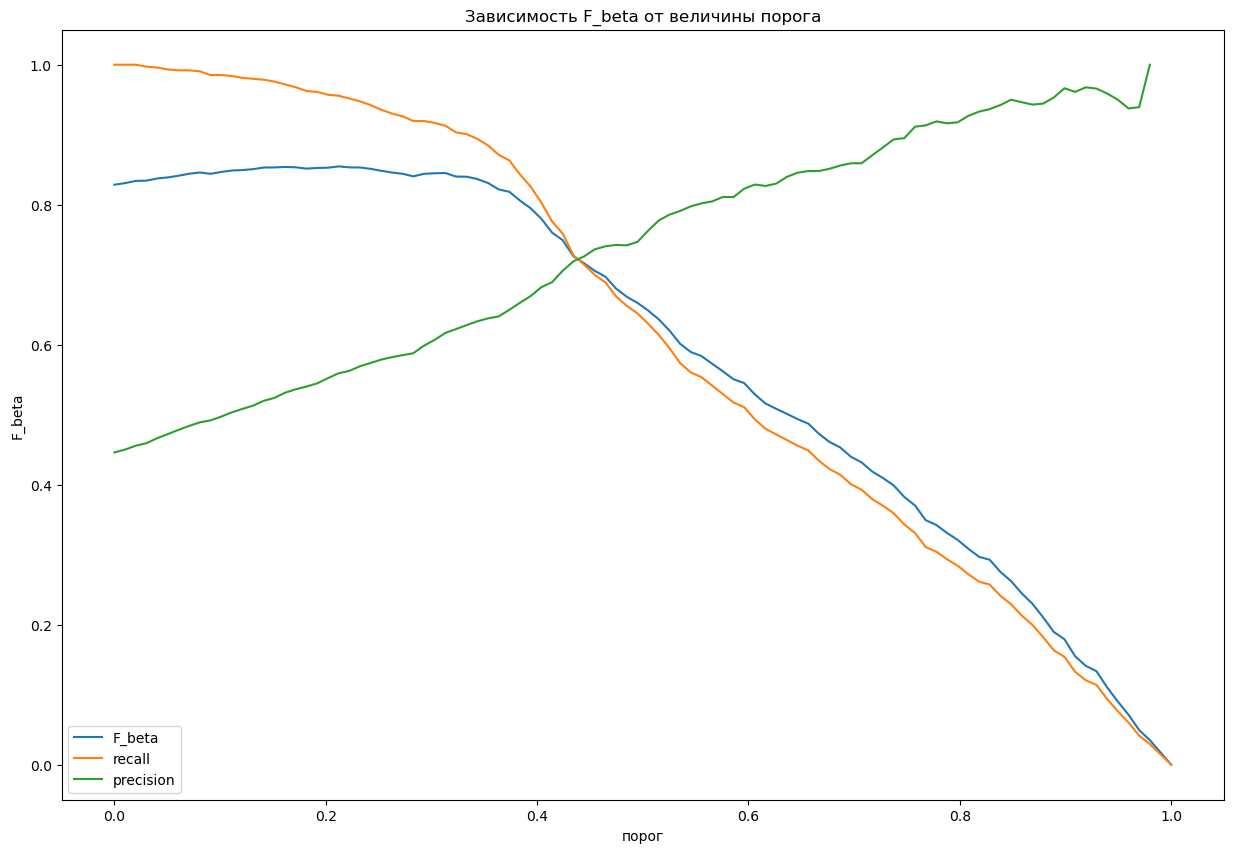

In [839]:
plt.figure(figsize=(15,10))
plt.plot(F_beta[1:,1], F_beta[1:,0], label='F_beta')
plt.plot(F_beta[1:,1], F_beta[1:,3], label='recall')
plt.plot(F_beta[1:99,1], F_beta[1:99,2], label='precision')

plt.title("Зависимость F_beta от величины порога")
plt.xlabel("порог")
plt.ylabel("F_beta");
plt.legend()
plt.show()

Как видно по графику, F_beta почти везде убывает по порогу, так как мы задали очень высокое влияние полноты, также убывающей при росте порога. В этом случае влияние точности наблюдается лишь в начале, когда ее рост компенсирует относительно медленное падение полноты, что немного увеличивает F_beta.

## Интерпретация модели [5 баллов]

Часто нам хочется интерпритировать предсказания модели - понять, как наши признаки влияют на её ответ.
В случае сложных моделей сделать это не просто - чем сложнее модель, тем более сложные закономерности она извлекает и тем тяжелее нам их понять.

Но в случае линейной регресии это просто сделать, посмотрев на её обучаемые параметры (вспоминайте!).

Получите список признаков, которые увеличивают вероятность метки 0.
Аналогично для метки 1.

In [840]:
prob_base = prob #сохраняю изначальные вероятности, когда есть все признаки

Точный метод получения списка признаков не указали, поэтому использую первый способ, пришедший мне в голову. Для того, чтобы определить признаки, уменьшающие вероятность метки 1, я решил просто поочередно выкидывать по 1 признаку, и смотреть, как это влияет на вероятности выпадения метки 1. Если вероятности в среднем уменьшились, то есть сумма разностей вероятностей между изначальным вариантом, где есть все признаки, и новым вариантом выборки, где все признаки кроме одного, отрицательна - значит вероятность метки 1 увеличилась, иначе - уменьшилась. 

In [841]:
incr_prob_1 = [] #список признаков увеличивающих 1
incr_prob_0 = [] #список признаков увеличивающих 0
for i in features:
    model = LogisticRegression(solver='lbfgs', penalty='l2', C=0.18329807108324356, max_iter=10, random_state=42)
    model.fit(minmax_scale(x_train.drop(i, axis=1)), y_train)
    #y_pred = model.predict(x_test) #использует порог 0.5, как и надо, так как уточнений не было
    prob = model.predict_proba(minmax_scale(x_test.drop(i, axis=1)))[:,1] #можно и вероятности первого класса вытащить
    if((prob_base-prob).sum() < 0):incr_prob_1.append(i)
    else: incr_prob_0.append(i)
print(incr_prob_0) #решил вывести только этот список, так как другой очень большой

['Аптеки', 'Галереи/учреждения видеоигр', 'Лесо- и строительный материал', 'Магазины с продажей спиртных напитков на вынос (пиво, вино и ликер)', 'Обувные магазины', 'Одежда для всей семьи', 'Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов', 'Рестораны, закусочные', 'Финансовые институты — снятие наличности автоматически']


В результате видно, что , вероятно, гендер 0 это мужчины, так как признаки увеличивающие вероятность метки 0 больше подходят для мужчин (особенно спиртные напитки на вынос( ͡° ͜ʖ ͡° )). Хотя это неточно, так как признаков очень много и они сами по себе слабо влияют на метку (это видно по величинам разниц prob_base-prob, которые всегда в районе 1-2, учитывая, что это сумма по всем юзерам). 

# Часть 4: ва-банк / пространство для творчества [макс 30 баллов]

Добейтесь максимального качества, больше качество - больше баллов.

Стратегия подготовки данных и обучения модели на ваше усмотрение.

Условия:
* Оценка на отложенной тестовой группе пользователей, использовавшейся в прошлых пунктах (20%)
* В качестве метрики используйте ROC_AUC

Для увеличения качетсва я думаю во-первых, уменьшить количество признаков, выбрав из них самые главные и во-вторых, проводить GridSearch одновременно и для solver-ов и для остальных параметров, хотя это и увеличит время компиляции

In [842]:
regress = [[0,0]]
for feature in features:
    k =  [float(f_regression(x_train[feature].to_frame() , y_train)[0]), feature] #собственно оценка "силы" признака
    regress.append(k)
best_features = sorted(regress[1:], key=lambda p: p[0], reverse = True)[:50] #берем лучшие 50 признаков
#best_features

Я снова написал бесполезный код, который имеет встроенные аналог у sklearn... Оствлю его сверху, можно сравнить с результатом функции SelectKBest, выводит одинаково, если у SelectKBest задать f_regression и соответствующий k (можно откомментить и посмотреть)

In [843]:
same_best_features = SelectKBest(f_regression, k=50).fit(minmax_scale(x_train), y_train) #лучшие по f_regression с k=50
same_best_features = same_best_features.get_feature_names_out(features) #выбираем нужные фичи
#same_best_features

In [844]:
model = LogisticRegression(random_state=42)
parameters = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag’, ‘saga'], 
    'penalty' : ['l1', 'l2', 'elasticnet'],  #я не знаю как, но работает без ошибок, несмотря на несовметимость некоторых солверов и пенальти
    'C' : np.logspace(-2, 4, 40),
}

grid = GridSearchCV(model, parameters, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(minmax_scale(x_train[same_best_features]), y_train)#применяем нормализацию и выбираем нужные признаки

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.42510267e-02, 2.03091762e-02, 2.89426612e-02,
       4.12462638e-02, 5.87801607e-02, 8.37677640e-02, 1.19377664e-01,
       1.70125428e-01, 2.42446202e-01, 3.45510729e-01, 4.92388263e-01,
       7.01703829e-01, 1.00000000e+00, 1.42510267e+00, 2.03091762e+00,
       2.89426612e+0...
       4.92388263e+01, 7.01703829e+01, 1.00000000e+02, 1.42510267e+02,
       2.03091762e+02, 2.89426612e+02, 4.12462638e+02, 5.87801607e+02,
       8.37677640e+02, 1.19377664e+03, 1.70125428e+03, 2.42446202e+03,
       3.45510729e+03, 4.92388263e+03, 7.01703829e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag’, ‘saga']},
             scoring='roc_auc')

In [845]:
model = LogisticRegression(solver=grid.best_params_['solver'], penalty=grid.best_params_['penalty'],
                           C=grid.best_params_['C'],
                           random_state=42)
model.fit(minmax_scale(x_train[same_best_features]), y_train)
prob = model.predict_proba(minmax_scale(x_test[same_best_features]))[:,1]
print('ROC_AUC:', roc_auc_score(y_test, prob))

ROC_AUC: 0.8349975969750838


Обычные методы по подбору нужных признаков не оказали влияния, метрика даже немного уменьшилась (я в SelectKBest перебирал всевозможные одномерные отборочные функции как : f_classif, f_regression, chi2, mutual_info_regression, связывающие признаки с целевой меткой). При увеличении количества признаков (k) метрика ROC_AUC стабильно росла, что говорит о низком качетве одномерных отборочных функций (или их непригодности к этому датасету). Поэтому подключим более мощный аппарат из библиотеки mlxtend (ее надо отдельно грузить).

In [846]:
efs = ExhaustiveFeatureSelector(LogisticRegression(),
        min_features=1, #минимальный размер комбинаций
        max_features=10, #максимальный размер комбинаций
        scoring='roc_auc',
        cv=10, n_jobs=-1)

efs = efs.fit(minmax_scale(x_train[same_best_features]), y_train)

KeyboardInterrupt: 

Этот перебор называется исчерпывающим, и он перебирает вообще ВСЕ кобинации признаков в указанных пределах. По идее, эта функция может найти самый оптимальный набор признаков, однако работает она нереально долго, тут обычного компа не хватит (я оставлял только лучшие фичи, найденные еще в SelectKBest, уменьшая их количество до 15, и все равно не дождался результата). Поэтому выберу что-нибудь попроще, например прямой отбор признаков.

In [739]:
sfs = SequentialFeatureSelector(LogisticRegression(), scoring='roc_auc',cv=5 , n_jobs=-1)
 
sfs.fit(minmax_scale(x_train[same_best_features]), y_train) #опять пришлось уменьшить число признаков до same_best_features, т.к.
new_best_features = sfs.get_feature_names_out(same_best_features)  #иначе не компилируется и за 10 минут

In [764]:
model = LogisticRegression(random_state=42)
parameters = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag’, ‘saga'],
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-2, 4, 20),
}

grid = GridSearchCV(model, parameters, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(minmax_scale(x_train[new_best_features]), y_train)#применяем нормализацию и выбираем нужные признаки

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.06913808e-02, 4.28133240e-02, 8.85866790e-02,
       1.83298071e-01, 3.79269019e-01, 7.84759970e-01, 1.62377674e+00,
       3.35981829e+00, 6.95192796e+00, 1.43844989e+01, 2.97635144e+01,
       6.15848211e+01, 1.27427499e+02, 2.63665090e+02, 5.45559478e+02,
       1.12883789e+03, 2.33572147e+03, 4.83293024e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag’, ‘saga']},
             scoring='roc_auc')

In [765]:
model = LogisticRegression(solver=grid.best_params_['solver'], 
                           penalty=grid.best_params_['penalty'],
                           C=grid.best_params_['C'], 
                           random_state=42)
model.fit(minmax_scale(x_train[new_best_features]), y_train)
prob = model.predict_proba(minmax_scale(x_test[new_best_features]))[:,1]
print('ROC_AUC:', roc_auc_score(y_test, prob))

ROC_AUC: 0.8199721770247657


Мда, качество упало еще сильнее. Я начинаю подозревать, что для увеличения качества нужно работать не с признаками. Что в принципе еще можно поменять? Пропущенные значения убирал, признаки перебирал, гиперпараметры подгонял, остается только изменить модель, но это делать нельзя. Попробуем поменять GridSearchCV на LogisticRegressionCV, может поможет (увидел на хабре, что кто-то так С оптимизирует).

In [759]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #решил заодно cv поменять

In [769]:
c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, scoring="roc_auc", verbose=1, n_jobs=-1)

logit_searcher.fit(minmax_scale(x_train), y_train)
prob = logit_searcher.predict_proba(minmax_scale(x_test))[:,1]
print('ROC_AUC:', roc_auc_score(y_test, prob))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.2s remaining:   40.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s finished


ROC_AUC: 0.8358929408971679


Это уже лучше, чем предыдущие результаты, где я пытался отбирать признаки и даже лучше, чем значение ROC_AUC из 3 части. Прогресс. Наконец, поробую последний вариант, где просто сделаю GridSearchCV на всех признаках, но в отличие от 3 части буду одновременно подбирать все гиперпараметры. 

In [766]:
model = LogisticRegression(random_state=42)
parameters = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag’, ‘saga'],
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-2, 4, 20),
    #'class_weight' : ['balanced', None], я пытался подгонять польше параметров, но это просто не компилится
    #'fit_intercept' : [True, False]
    #'max_iter' : np.linspace(0, 150, 15, dtype=int)
}

grid = GridSearchCV(model, parameters, cv=skf, scoring="roc_auc", n_jobs=-1)
grid.fit(minmax_scale(x_train), y_train)#применяем нормализацию и выбираем нужные признаки

{'C': 0.08858667904100823, 'penalty': 'l2', 'solver': 'liblinear'}
0.8130325979161178


In [768]:
model = LogisticRegression(solver=grid.best_params_['solver'], 
                           penalty=grid.best_params_['penalty'],
                           C=grid.best_params_['C'], 
                           random_state=42)
model.fit(minmax_scale(x_train), y_train)
prob = model.predict_proba(minmax_scale(x_test))[:,1]
print('ROC_AUC:', roc_auc_score(y_test, prob))

ROC_AUC: 0.8359370928609893


О чудо, результат еще немного увеличился, на целых 0.00004. Может это предел для логистической регрессии и преоделеть даже 84% нельзя? Последним рывком попробую добавить признаки из части 1 к общему списку признаков, хотя не уверен, можно ли это по условию.

In [803]:
last_chance = last_chance1.merge(last_chance2, how='outer', left_index=True, right_index=True)

In [805]:
df_train, df_test = train_test_split(last_chance, test_size = 0.2, stratify=last_chance['gender'],  random_state=42)
y_train = df_train['gender']  #целевая переменная для test-а и train-а
y_test = df_test['gender']

x_train = df_train.drop('gender', axis=1)   #регрессоры для test-а и train-а
x_test = df_test.drop('gender', axis=1)

In [807]:
model = LogisticRegression(random_state=42)
parameters = {
    'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
    'C' : np.logspace(-2, 4, 20),
    #'penalty' : ['l1', 'l2', 'elasticnet'], теперь, грид начал падать, если не разделять солверы, оч странно
}

grid = GridSearchCV(model, parameters, cv=skf, scoring="roc_auc", n_jobs=-1)
grid.fit(minmax_scale(x_train), y_train)#применяем нормализацию и выбираем нужные признаки

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.06913808e-02, 4.28133240e-02, 8.85866790e-02,
       1.83298071e-01, 3.79269019e-01, 7.84759970e-01, 1.62377674e+00,
       3.35981829e+00, 6.95192796e+00, 1.43844989e+01, 2.97635144e+01,
       6.15848211e+01, 1.27427499e+02, 2.63665090e+02, 5.45559478e+02,
       1.12883789e+03, 2.33572147e+03, 4.83293024e+03, 1.00000000e+04]),
                         'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                    'sag']},
             scoring='roc_auc')

In [808]:
model = LogisticRegression(solver=grid.best_params_['solver'], 
                           penalty='l2',
                           C=grid.best_params_['C'], 
                           random_state=42)
model.fit(minmax_scale(x_train), y_train)
prob = model.predict_proba(minmax_scale(x_test))[:,1]
print('ROC_AUC:', roc_auc_score(y_test, prob))

ROC_AUC: 0.836333012930011


Опа, еще рост на целых 0.0004, прирост в тысячу раз больше, чем прошлый раз. Проверим оставшиеся солверы. 

In [810]:
model = LogisticRegression(solver='liblinear', random_state=42)
parameters = {
    #'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
    'C' : np.logspace(-2, 4, 20),
    'penalty' : ['l1', 'l2'], #теперь, грид начал падать, если не разделять солверы, оч странно
}

grid = GridSearchCV(model, parameters, cv=skf, scoring="roc_auc", n_jobs=-1)
grid.fit(minmax_scale(x_train), y_train)#применяем нормализацию и выбираем нужные признаки
model = LogisticRegression(solver='liblinear', 
                           penalty=grid.best_params_['penalty'],
                           C=grid.best_params_['C'], 
                           random_state=42)
model.fit(minmax_scale(x_train), y_train)
prob = model.predict_proba(minmax_scale(x_test))[:,1]
print('ROC_AUC:', roc_auc_score(y_test, prob))

ROC_AUC: 0.8362273377379139


Падение, liblinear хуже. Допроверяем saga.

In [811]:
model = LogisticRegression(solver='saga', random_state=42)
parameters = {
    #'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
    'C' : np.logspace(-2, 4, 20),
    'penalty' : ['l1', 'l2', 'elasticnet'], #теперь, грид начал падать, если не разделять солверы, оч странно
}

grid = GridSearchCV(model, parameters, cv=skf, scoring="roc_auc", n_jobs=-1)
grid.fit(minmax_scale(x_train), y_train)#применяем нормализацию и выбираем нужные признаки
model = LogisticRegression(solver='saga', 
                           penalty=grid.best_params_['penalty'],
                           C=grid.best_params_['C'], 
                           random_state=42)
model.fit(minmax_scale(x_train), y_train)
prob = model.predict_proba(minmax_scale(x_test))[:,1]
print('ROC_AUC:', roc_auc_score(y_test, prob))

ROC_AUC: 0.8363315653246399


Тоже хуже. Вот и все, победитель найден. Итоговый прирост качества по сравнению с 3 частью = $0.836333012930011 - 0.8359392642690461 = 0.00039$. Маловато будет, но я пытался. Видимо, все-таки нужны модели получше, либо мой комп из каменного века.